In [1]:
from mltoolbox.basic import *
from mltoolbox.plotting import save_spectrogram

In [2]:
import pyarrow.parquet as pq
from pathlib import Path

In [3]:
PATH = Path('data/')

In [4]:
import os

In [6]:
os.mkdir('data/train_spectograms/')

In [5]:
train = pq.read_pandas(PATH/'train.parquet').to_pandas()

In [6]:
train.iloc[:, :5].head()

,0,1,2,3,4
0,18,1,-19,-16,-5
1,18,0,-19,-17,-6
2,17,-1,-20,-17,-6
3,18,1,-19,-16,-5
4,18,0,-19,-16,-5


In [7]:
from scipy import signal

In [10]:
SAMPLE_LENGTH = 800000
SAMPLE_TIME = 20e-3     # in second
SAMPLING_RATE = SAMPLE_LENGTH / SAMPLE_TIME

# Spectograms

In [11]:
def make_spectograms(idx):
    data = train.iloc[:, idx]
    residual = data - data.ewm(alpha=0.01).mean()
    f, t, Sxx = signal.spectrogram(x=residual, fs=SAMPLING_RATE,
                                   window='hamming', nperseg=50000,
                                   nfft=SAMPLE_LENGTH)
    save_spectrogram(Sxx, fpath='data/train_spectograms/' + f'{idx}.jpg',
                     log_col=True, log_freq=True)

In [14]:
import warnings
warnings.simplefilter('ignore')

In [15]:
make_spectograms(0)

Checking Image

![Image](data/train_spectograms/9.jpg)

In [16]:
_ = parallel(make_spectograms, range(0, 10), n_jobs=7)

In [24]:
!ls data/train_spectograms/

0.jpg	 15.jpg  25.jpg  35.jpg  45.jpg  55.jpg  65.jpg  75.jpg  85.jpg  95.jpg
100.jpg  16.jpg  26.jpg  36.jpg  46.jpg  56.jpg  66.jpg  76.jpg  86.jpg  96.jpg
101.jpg  17.jpg  27.jpg  37.jpg  47.jpg  57.jpg  67.jpg  77.jpg  87.jpg  97.jpg
102.jpg  18.jpg  28.jpg  38.jpg  48.jpg  58.jpg  68.jpg  78.jpg  88.jpg  98.jpg
103.jpg  19.jpg  29.jpg  39.jpg  49.jpg  59.jpg  69.jpg  79.jpg  89.jpg  99.jpg
104.jpg  1.jpg	 2.jpg	 3.jpg	 4.jpg	 5.jpg	 6.jpg	 7.jpg	 8.jpg	 9.jpg
10.jpg	 20.jpg  30.jpg  40.jpg  50.jpg  60.jpg  70.jpg  80.jpg  90.jpg
11.jpg	 21.jpg  31.jpg  41.jpg  51.jpg  61.jpg  71.jpg  81.jpg  91.jpg
12.jpg	 22.jpg  32.jpg  42.jpg  52.jpg  62.jpg  72.jpg  82.jpg  92.jpg
13.jpg	 23.jpg  33.jpg  43.jpg  53.jpg  63.jpg  73.jpg  83.jpg  93.jpg
14.jpg	 24.jpg  34.jpg  44.jpg  54.jpg  64.jpg  74.jpg  84.jpg  94.jpg


In [25]:
job_list = [int(i) for i in train.columns.values][104:]

In [26]:
_ = parallel(make_spectograms, job_list, n_jobs=6)

# GADF

In [8]:
from mltoolbox.image import *

In [9]:
SAMPLE_LENGTH = 800000
SAMPLE_TIME = 20e-3
SAMPLING_RATE = SAMPLE_LENGTH / SAMPLE_TIME

In [10]:
from scipy import fftpack

In [118]:
def shift_phase2zero(data):
    """
    smoothed_data = data.rolling(window=2001, center=True).mean().ewm(alpha=0.001
                                                                      ).mean()
                                                        # .bfill(limit=1000
                                                        # ).ffill(limit=1000)
    """
    sig_fft = fftpack.fft(data)
    sig_freq = fftpack.fftfreq(SAMPLE_LENGTH, 1 / SAMPLING_RATE)
    sig_fft[np.abs(sig_freq) > 400] = 0
    smoothed_data = fftpack.ifft(sig_fft)

    crossing_idx = np.where((smoothed_data[:-1] * smoothed_data[1:]) <= 0)

    if len(crossing_idx[0]) > 2:
        sig_fft = fftpack.fft(x.values)
        sig_freq = fftpack.fftfreq(SAMPLE_LENGTH, 1 / SAMPLING_RATE)
        sig_fft[np.abs(sig_freq) > 100] = 0
        smoothed_data = fftpack.ifft(sig_fft)
        crossing_idx = np.where((smoothed_data[:-1] * smoothed_data[1:]) <= 0)

    idx = None
    crossing_idx = [i for i in crossing_idx[0] if abs(i - SAMPLE_LENGTH) > 500]
    crossing_idx = [i for i in crossing_idx if i > 500]

    for z_idx in crossing_idx:
        if (smoothed_data[z_idx - 500] < 0) and\
                (smoothed_data[z_idx + 500] > 0):
            idx = z_idx
        else:
            pass

    if idx is None:
        return data
    else:
        return np.concatenate([data[idx:], data[:idx]])

In [12]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


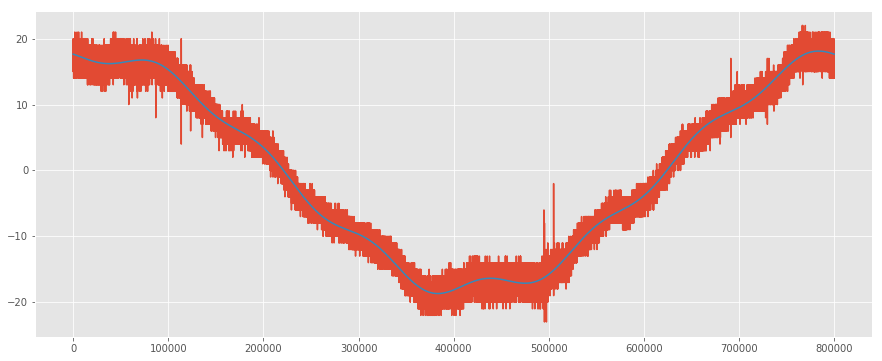

In [13]:
x = train.iloc[:, np.random.randint(0, 27)]
plt.plot(x)
sig_fft = fftpack.fft(x.values)
sig_freq = fftpack.fftfreq(SAMPLE_LENGTH, 1 / SAMPLING_RATE)
sig_fft[np.abs(sig_freq) > 400] = 0
smoothed_data = fftpack.ifft(sig_fft)
plt.plot(smoothed_data)

In [14]:
from scipy import signal
from scipy.signal import butter

In [15]:
def high_pass_filter(signals, low_freq=1000, sample_fs=SAMPLING_RATE):
    sos = butter(10, low_freq, btype='hp', fs=sample_fs, output='sos')
    filtered_sig = signal.sosfilt(sos, signals)
    return filtered_sig

In [16]:
from pyts.image import GADF

In [17]:
gadf = GADF(image_size=512)

In [18]:
os.makedirs('data/gadf_grams')

In [19]:
cmap = plt.get_cmap('viridis')

def make_gadf(sig_idx):
    x = train.iloc[:, sig_idx]
    x = shift_phase2zero(x)
    x = high_pass_filter(x)
    x = gadf.fit_transform(np.expand_dims(x, axis=0))
    plt.ioff()
    fig, ax = plt.subplots(1)
    fig.set_size_inches(5.12, 5.12)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    plt.imshow(x[0], cmap=cmap, origin='lower')
    plt.savefig(f'data/gadf_grams/{sig_idx}.jpg', dpi=100, frameon='false')
    plt.close(fig)
    return True

In [20]:
make_gadf(1)

True

In [21]:
train.shape

(800000, 8712)

In [34]:
_ = parallel(make_gadf, range(0, 8712), n_jobs=7)

In [120]:
done = !ls data/gadf_grams/

In [111]:
done = [int(f.split('.')[0]) for f in done]

In [112]:
done = set(done)

In [113]:
total = set(range(0, 8712))

In [114]:
np.array(list(total - done))

array([7426, 7427, 5643, 5644, 2572, 2573, 5645,  144,  145,  146, 6331,
       6398, 5446, 1741, 1742, 6990, 6991, 2386, 2387,  348, 7906, 7907,
       3300, 3564, 3565, 3566, 8691, 8692, 8693, 6396, 6397, 4606])

In [119]:
_ = parallel(make_gadf, list(total - done), n_jobs=1)

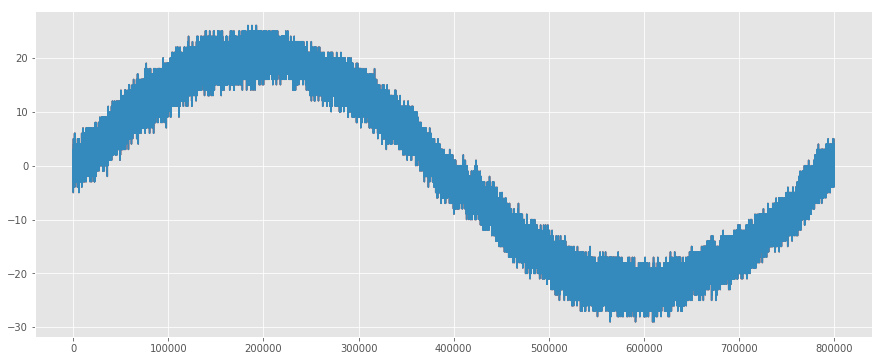

In [98]:
plt.plot(train.iloc[:, 3300])
plt.plot(shift_phase2zero(train.iloc[:, 3300]))

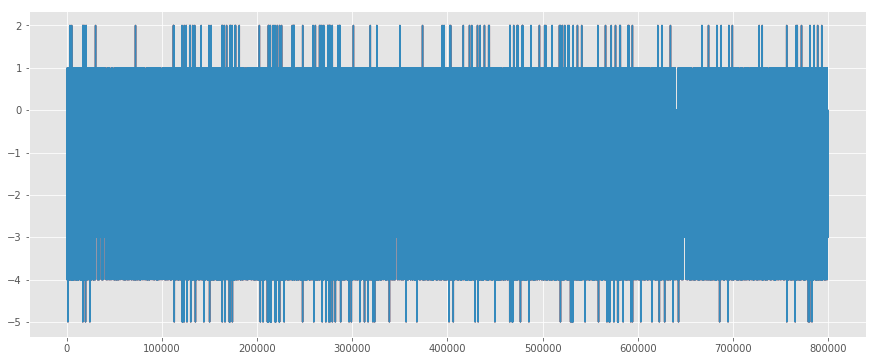

In [99]:
plt.plot(train.iloc[:, 5644])
plt.plot(shift_phase2zero(train.iloc[:, 5644]))

(array([137830, 532926, 570250, 585263]),)
(array([167777, 570315]),)
[167777, 570315]
167777


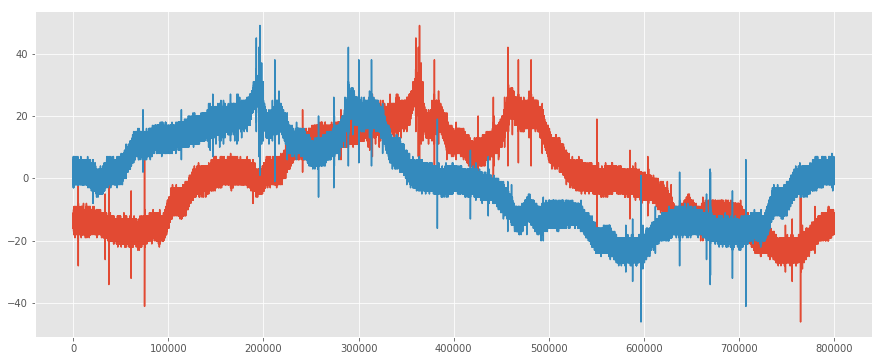

In [109]:
x = train.iloc[:, 7427]
plt.plot(x)
plt.plot(shift_phase2zero(x))

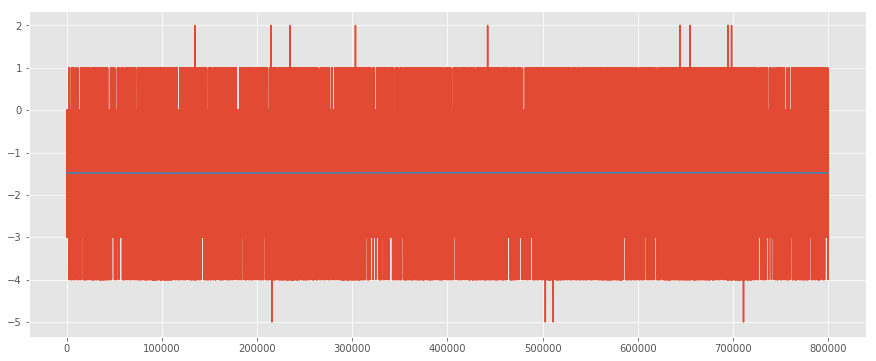

In [96]:
x = train.iloc[:, 6990]
plt.plot(x)
sig_fft = fftpack.fft(x.values)
sig_freq = fftpack.fftfreq(SAMPLE_LENGTH, 1 / SAMPLING_RATE)
sig_fft[np.abs(sig_freq) > 100] = 0
smoothed_data = fftpack.ifft(sig_fft)
plt.plot(smoothed_data)

In [121]:
len(done)

8712